In [1]:
import sys
import copy
import random
import hashlib
import cupy as cp 
import numpy as np
from math import pi
import numpy.linalg as LA
from os.path import abspath, join
sys.path.append(abspath(join('..')))
sys.path.append(abspath(join('../..')))

from datetime import datetime
from os.path import expanduser

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from LevelSetPy.Grids import *
from LevelSetPy.Utilities import *
from LevelSetPy.Visualization import *
from LevelSetPy.DynamicalSystems import *
from LevelSetPy.BoundaryCondition import *
from LevelSetPy.InitialConditions import *
from LevelSetPy.SpatialDerivative import *
from LevelSetPy.ExplicitIntegration import *
from BRATVisualization.rcbrt_visu import RCBRTVisualizer

%matplotlib inline

In [2]:

def visualize_init_avoid_tube(flock, save=True, fname=None, title=''):
	"""
		For a flock, whose mesh has been precomputed, 
		visualize the initial backward avoid tube.
	"""
	# visualize avoid set 
	fontdict = {'fontsize':16, 'fontweight':'bold'}
	mesh_bundle = flock.mesh_bundle
		
	fig = plt.figure(1, figsize=(16,9), dpi=100)
	ax = plt.subplot(111, projection='3d')
	ax.add_collection3d(mesh_bundle.mesh)


	xlim = (mesh_bundle.verts[:, 0].min(), mesh_bundle.verts[:,0].max())
	ylim = (mesh_bundle.verts[:, 1].min(), mesh_bundle.verts[:,1].max())
	zlim = (mesh_bundle.verts[:, 2].min(), mesh_bundle.verts[:,2].max())

	# create grid that contains just this zero-level set to avoid computational craze 
	gmin = np.asarray([[xlim[0], ylim[0], zlim[0]]]).T
	gmax = np.asarray([[xlim[1], ylim[1], zlim[1]]]).T

	# create reduced grid upon which this zero level set dwells
	flock.grid_zero = createGrid(gmin, gmax, flock.grid.N, 2)

	ax.set_xlim(xlim)
	ax.set_ylim(ylim)
	ax.set_zlim(zlim)

	ax.grid('on')
	ax.tick_params(axis='both', which='major', labelsize=10)

	ax.set_xlabel(rf'x$_1^{flock.label}$ (m)', fontdict=fontdict)
	ax.set_ylabel(rf'x$_2^{flock.label}$ (m)', fontdict=fontdict)
	ax.set_zlabel(rf'$\omega^{flock.label} (rad)$',fontdict=fontdict)

	if title:
		ax.set_title(title, fontdict=fontdict)
	else:
		ax.set_title(f'Flock {flock.label}\'s ({flock.N} Agents) Payoff.', fontdict=fontdict)
	ax.view_init(azim=-45, elev=30)

	if save:
		plt.savefig(fname, bbox_inches='tight',facecolor='None')

u_bound = 1
w_bound = 1 
def get_avoid_brt(flock, compute_mesh=True, color='crimson'):
	"""
		Get the avoid BRT for this flock. That is, every bird
		within a flock must avoid one another.

		Parameters:
		==========
		.flock: This flock of vehicles.
		.compute_mesh: compute mesh of local payoffs for each bird in this flock?
	"""
	for vehicle in flock.vehicles:
		# make the radius of the target setthe turn radius of this vehicle
		vehicle.payoff = shapeCylinder(flock.grid, 2, center=flock.update_state(vehicle.cur_state), \
										radius=vehicle.payoff_width)
	"""
		Now compute the overall payoff for the flock
	   	by taking a union of all the avoid sets.
	"""
	flock.payoff = shapeUnion([veh.payoff for veh in flock.vehicles])
	if compute_mesh:
		spacing=tuple(flock.grid.dx.flatten().tolist())
		flock.mesh_bundle = implicit_mesh(flock.payoff, 0, spacing,edge_color=None, face_color=color)

	return flock


def get_flock(gmin, gmax, num_points, num_agents, init_xyzs, label,\
				periodic_dims=2, reach_rad=.2, avoid_rad=.3,
				base_path='', save=True, color='blue'):
	"""
		Params
		======
		gmin: minimum bounds of the grid
		gmax: maximum bounds of the grid
		num_points: number of points on the grid
		num_agents: number of agents in this flock
		init_xyzs: initial positions of the individuals in this flock
		label: topological label of this flock among all flocks
		periodic_dims: periodic dimensions (usually theta: see)
		reach_rad: reach for external disturbance
		avoid_rad: avoid radius for topological interactions
	"""
	global u_bound, w_bound

	assert gmin.ndim==2, 'gmin must be of at least 2 dims'
	assert gmax.ndim==2, 'gmax must be of at least 2 dims'

	gmin = to_column_mat(gmin)
	gmax = to_column_mat(gmax)

	grid = createGrid(gmin, gmax, num_points, periodic_dims)

	vehicles = [Bird(grid, u_bound, w_bound, np.expand_dims(init_xyzs[i], 1), random.random(), \
					center=np.zeros((3,1)), neigh_rad=3, label=i+1, init_random=False) \
					for i in range(num_agents)]
	flock = Flock(grid, vehicles, label=label, reach_rad=.2, avoid_rad=.3)
	get_avoid_brt(flock, compute_mesh=True, color=color)

	if args.visualize and args.flock_payoff:
		visualize_init_avoid_tube(flock, save, fname=join(base_path, f"flock_{flock.label}.jpg"))
		plt.show()

	return flock

In [3]:
args = Bundle(dict(visualize=True, flock_num=4, flock_payoff=False, pause_time=1e-5))

In [6]:
gmin = np.asarray([[-1.5, -1.5, -np.pi]]).T
gmax = np.asarray([[1.5, 1.5, np.pi] ]).T
num_agents = 7

H         = 0.4
H_STEP    = 0.05
neigh_rad = 0.4
reach_rad = .2

INIT_XYZS = np.array([[neigh_rad*np.cos((i/6)*np.pi/4), neigh_rad*np.sin((i/6)*np.pi/4), H+i*H_STEP] for i in range(num_agents)])

# color thingy
color = iter(plt.cm.inferno_r(np.linspace(.25, 1, num_agents)))

# save shenanigans
base_path = join(expanduser("~"), "Documents/Papers/Safety/WAFR2022/figures", 
                    f"flock_{args.flock_num}",
                    datetime.strftime(datetime.now(), '%m-%d-%y_%H-%M'))

assert args.flock_num<7 and args.flock_num>=0, "Unknown flock number entered."
mul_factors = [1, 1.1, -1.1, 1.5, -1.5, 2.0, -1.8]
scaling_factor = mul_factors[args.flock_num]	
num_agents -= (args.flock_num%2)
flock = get_flock(gmin, gmax, 101, num_agents, scaling_factor*INIT_XYZS, label=7,\
                periodic_dims=2, reach_rad=.2, avoid_rad=.3, base_path=base_path, \
                color=next(color))


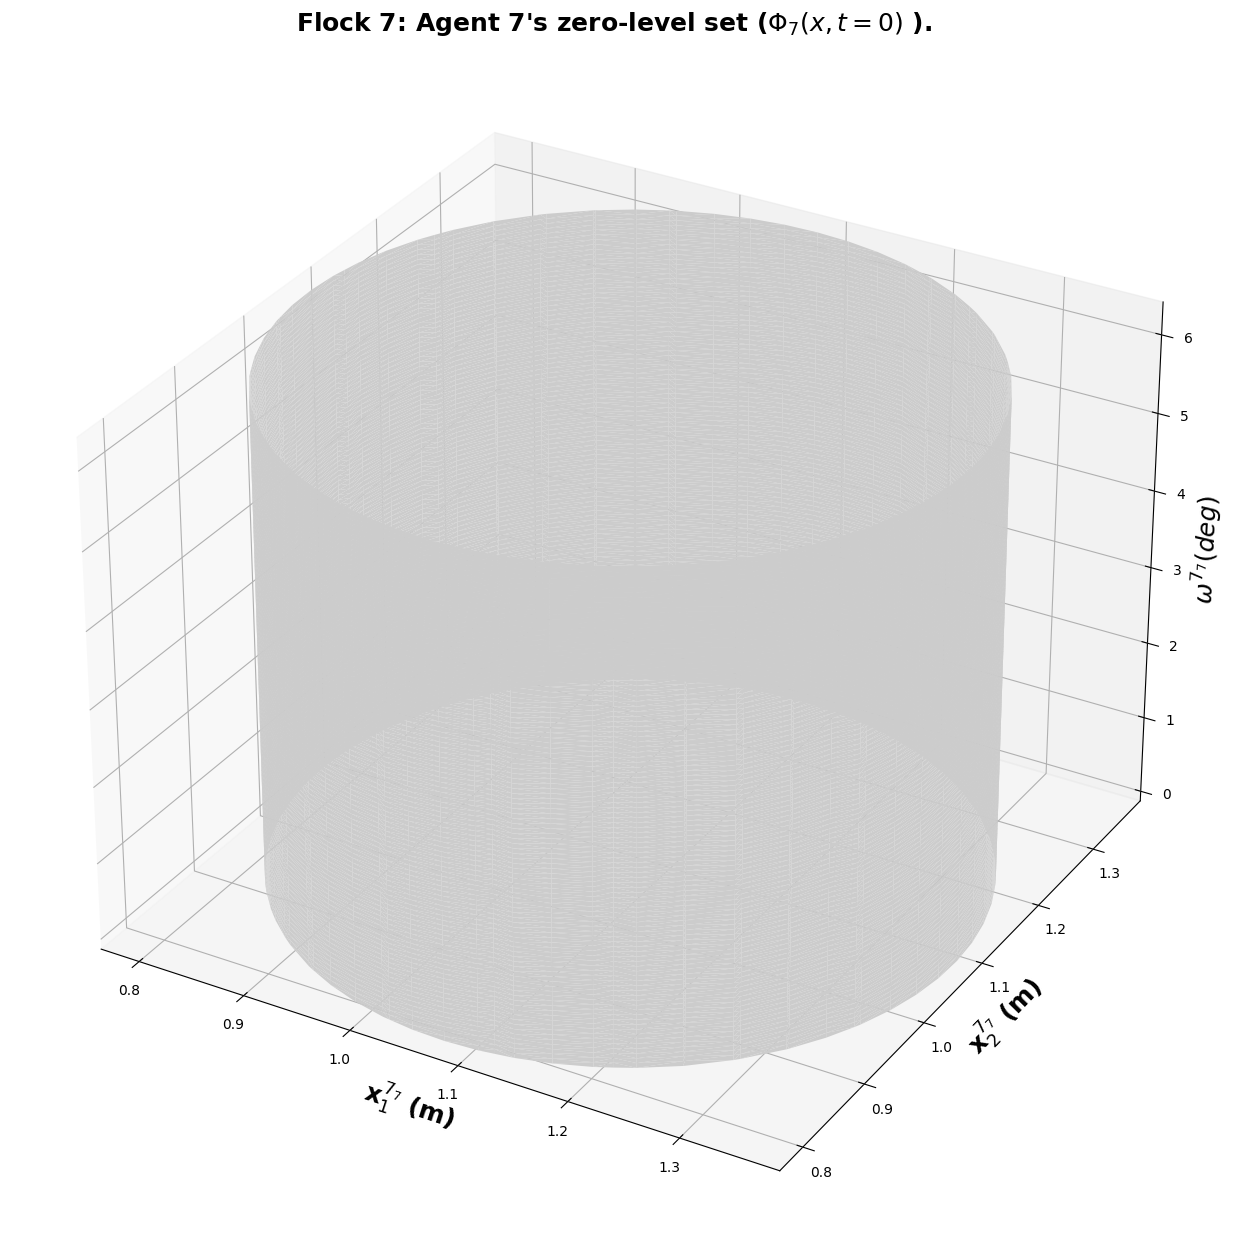

In [22]:
import time

#plot all the payoffs in this flock
fontdict = {'fontsize':18, 'fontweight':'bold'}
plt.ion()

fig = plt.figure(1, figsize=(25,16), dpi=100)
ax = plt.subplot(111, projection='3d')

spacing=tuple(flock.grid.dx.flatten().tolist())
color = iter(plt.cm.nipy_spectral(np.linspace(0.01, 1, len(flock.vehicles))))
# print(color)
idx = 0
for vehicle in flock.vehicles:

    # compute implicit mesh
    # print(vehicle.payoff)
    mesh_bundle = implicit_mesh(vehicle.payoff, 0, spacing,edge_color=None, face_color=next(color))
    
    ax.grid('on')
    plt.cla()

    ax.add_collection3d(mesh_bundle.mesh)
    xlim = (mesh_bundle.verts[:, 0].min(), mesh_bundle.verts[:,0].max())
    ylim = (mesh_bundle.verts[:, 1].min(), mesh_bundle.verts[:,1].max())
    zlim = (mesh_bundle.verts[:, 2].min(), mesh_bundle.verts[:,2].max())

    ax.set_xlim3d(*xlim)
    ax.set_ylim3d(*ylim)
    ax.set_zlim3d(*zlim)

    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_title(rf"Flock {flock.label}: Agent {idx+1}'s zero-level set ($\Phi_{idx+1}(x, t=0)$ ).", fontdict=fontdict)

    ax.set_xlabel(rf'x$_1^{{({idx+1})_{flock.label}}}$ (m)', fontdict=fontdict)
    ax.set_ylabel(rf'x$_2^{{({idx+1})_{flock.label}}}$ (m)', fontdict=fontdict)
    ax.set_zlabel(rf'$\omega^{{({idx+1})_{flock.label}}} (deg)$',fontdict=fontdict)

    fig.canvas.draw()
    fig.canvas.flush_events()

    savepath = join(expanduser("~"), "Documents", "Papers", "Safety", "WAFR2022", "figures")
    os.makedirs(savepath) if not os.path.exists(savepath) else None
    fig.savefig(join(savepath, rf"agent_{idx:0>4}.jpg"), \
                        bbox_inches='tight',facecolor='None')

    time.sleep(1e-5)

    idx+= 1

$\epsilon$

In [5]:
finite_diff_data = Bundle(dict(innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid':flock.grid,
                'hamFunc': flock.hamiltonian,
                'partialFunc': flock.dissipation,
                'dissFunc': artificialDissipationGLF,
                'CoStateCalc': upwindFirstWENO5a, 
                }),
                positive = False,  # direction to grow the updated level set
            ))

# Visualization paramters
params = Bundle(
                {"grid": flock.grid,
                    'disp': True,
                    'labelsize': 16,
                    'labels': "Initial 0-LevelSet",
                    'linewidth': 2,
                    'elevation': 10,
                    'azimuth': 5,
                    'mesh': flock.mesh_bundle,
                    'pause_time': args.pause_time,
                    'title': f'Initial BRT. Flock with {flock.N} agents.',
                    'level': 0, # which level set to visualize
                    'winsize': (16,9),
                    'fontdict': {'fontsize':18, 'fontweight':'bold'},
                    "savedict": Bundle({"save": True,
                                "savename": "murmur",
                                "savepath": join(expanduser("~"),
                                "Documents/Papers/Safety/WAFR2022/figures/")
                                })
                })


### Load the BRATSs from a previous iteration

In [ ]:
import h5py
import time
import matplotlib.pyplot as plt

# recreate spacing

gmin = np.asarray([[-1.5, -1.5, -np.pi]]).T
gmax = np.asarray([[1.5, 1.5, np.pi] ]).T
grid = createGrid(gmin, gmax, 101, 2)
spacing = tuple(grid.dx.flatten().tolist())

def see(n, obj):
    keys = []
    for k, v in obj.attrs.items():
        keys.append((k,v))
    return keys

verbose = False
fname = '../data/murmurations_flock1_02-04-22_00-35.hdf5'


fontdict = {'fontsize':16, 'fontweight':'bold'}

plt.ion()
fig = plt.figure(1, figsize=(16,9), dpi=100)
ax = plt.subplot(111, projection='3d')

with h5py.File(fname, 'r+') as df:
    if verbose:
        df.visititems(see)
    
    value_key = [k for k in df.keys()][0]
    keys = [key for key in df[value_key]]

    # load them brats for a flock
    colors = iter(plt.cm.turbo(np.linspace(0, len(keys), len(keys))))
    for key in keys:
        brt = np.asarray(df[f"{value_key}/{key}"])
        brt_cp = cp.asarray(brt)
        print(brt_cp.shape, type(brt_cp))

        mesh_bundle=implicit_mesh(brt, level=0, spacing=spacing,
                                edge_color=None,  face_color=next(colors))

        ax.grid('on')
        plt.cla()

        ax.add_collection3d(mesh_bundle.mesh)
        xlim = (mesh_bundle.verts[:, 0].min(), mesh_bundle.verts[:,0].max())
        ylim = (mesh_bundle.verts[:, 1].min(), mesh_bundle.verts[:,1].max())
        zlim = (mesh_bundle.verts[:, 2].min(), mesh_bundle.verts[:,2].max())

        ax.set_xlim3d(*xlim)
        ax.set_ylim3d(*ylim)
        ax.set_zlim3d(*zlim)

        ax.tick_params(axis='both', which='major', labelsize=10)

        ax.set_xlabel(rf'x$_1^{1}$ (m)', fontdict=fontdict)
        ax.set_ylabel(rf'x$_2^{1}$ (m)', fontdict=fontdict)
        ax.set_zlabel(rf'$\omega^{1} (rad)$',fontdict=fontdict)

        ax.set_title(f'BRT at {key} secs.', fontdict=fontdict)
        ax.view_init(azim=-30, elev=30)

        fig.canvas.draw()
        fig.canvas.flush_events()

        time.sleep(.3)
        
        break 

plt.ioff()

In [45]:
import os
base_path = "/opt/murmurations/"
murmur_files = sorted([m for m in os.listdir(base_path) if m.startswith('murmurations')])
print(murmur_files)

['murmurations_flock_00_02-08-22_02-52.hdf5', 'murmurations_flock_01_02-06-22_17-43.hdf5', 'murmurations_flock_02_02-06-22_22-36.hdf5', 'murmurations_flock_03_02-07-22_20-03.hdf5', 'murmurations_flock_04_02-07-22_15-44.hdf5', 'murmurations_flock_05_02-07-22_18-05.hdf5', 'murmurations_flock_06_02-07-22_23-24.hdf5']


In [64]:
import h5py
murmur_dict = {f"flock_{fname.split(sep='_')[2]}": {'spacing': None, 'time': []} for fname in murmur_files}
# {k:g.attrs['mapped_id'] for k,g in hf['structures'].items()}
print(murmur_dict)

{'flock_00': {'spacing': None, 'time': []}, 'flock_01': {'spacing': None, 'time': []}, 'flock_02': {'spacing': None, 'time': []}, 'flock_03': {'spacing': None, 'time': []}, 'flock_04': {'spacing': None, 'time': []}, 'flock_05': {'spacing': None, 'time': []}, 'flock_06': {'spacing': None, 'time': []}}


In [69]:
murmur_dict = {f"flock_{fname.split(sep='_')[2]}": {'spacing': None, 'time': []} for fname in murmur_files}

idx = 0
for f in murmur_files:
    flock_num = f.split(sep='_')[2]
    # load each brt stack
    with h5py.File(join(base_path, f), 'r+') as df:
        value_key = [k for k in df.keys()][0]
        keys = [key for key in df[value_key]]
        if 'spacing' in value_key:
            spacing = np.asarray(df["value/spacing"])
        else:
            gmin = np.asarray([[-1.5, -1.5, -np.pi]]).T
            gmax = np.asarray([[1.5, 1.5, np.pi] ]).T
            grid = createGrid(gmin, gmax, 101, 2)
            spacing = grid.dx.flatten()      
        murmur_dict[f'flock_{flock_num}']['spacing'] = tuple(spacing.tolist())

        idx = 0
        for key in keys[1:]:
            murmur_dict[f'flock_{flock_num}']['time'] += [key]
            murmur_dict[f'flock_{flock_num}'][f'{idx:0>3}'] = np.asarray(df[f"{value_key}/{key}"])
            idx += 1

In [68]:
murmur_dict[f'flock_{flock_num}'].keys()

dict_keys(['spacing', 'time', '000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '097', '098', '099', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138